In [1]:
# include("../src/Kalman.jl")
using PyPlot
plt.style.use("seaborn-darkgrid");
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
"#8c564b", "#e377c2", "#7f7f7f","#bcbd22", "#17becf"];


In [2]:
using Revise
using KalmanFilter
using BenchmarkTools
using LinearAlgebra
using Random
using Statistics

┌ Info: Precompiling KalmanFilter [20f8213b-fd9a-4149-ad26-e11fe7a9a3e8]
└ @ Base loading.jl:1278
┌ Warning: Package KalmanFilter does not have LinearAlgebra in its dependencies:
│ - If you have KalmanFilter checked out for development and have
│   added LinearAlgebra as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with KalmanFilter
└ Loading LinearAlgebra into KalmanFilter from project dependency, future warnings for KalmanFilter are suppressed.


In [3]:
using Pkg
Pkg.resolve()

No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [170]:
T = 0.1
σ_x = 10.0
σ_y = 10.0
F = [1. T ;
     0. 1.]
# G = [0.5T^2, T, 1.0]
G = [0.5*T^2; T]
H = [1.0 0.0]
Q = σ_x .* G*G'
R = [σ_y]

1-element Array{Float64,1}:
 10.0

In [171]:
function true_process(n_step)
    rng = MersenneTwister()
    x_true = zeros((2, n_step))
    y_true = zeros(n_step)
    for i in 2:n_step
        w = randn(rng, Float64, (1,1)) * σ_x
        v = randn(rng, Float64, 1) * σ_y
        x_true[:,i] = F * x_true[:,i-1] .+ G * w
        y_true[i] = H * x_true[:,i] + v |> first
    end
    return x_true, y_true
end
true_process(10)

([0.0 0.03729084260839868 … -1.1168698190590716 -1.297222214220755; 0.0 0.7458168521679736 … -1.2017541738850703 -2.405293729348598], [0.0, -3.174772252975349, -2.985166553948687, 1.221083982438825, 3.1758175267197273, -3.3124101867784943, -3.1268455575711718, -2.9759156438131127, 3.889580865320357, -24.426727077787437])

In [172]:
n_step = 300
t = collect(1:n_step) ./ 10
x_true, y_true = true_process(n_step)
# @code_warntype 
k = Kalman(y = y_true, F=F, G=G, H=H,Q=Q, R=R, x0=[0.0, 0.0], V0=diagm(ones(2)));

In [173]:
KalmanFilter.kalman_filter!(k)

In [174]:
KalmanFilter.kalman_smooth!(k)

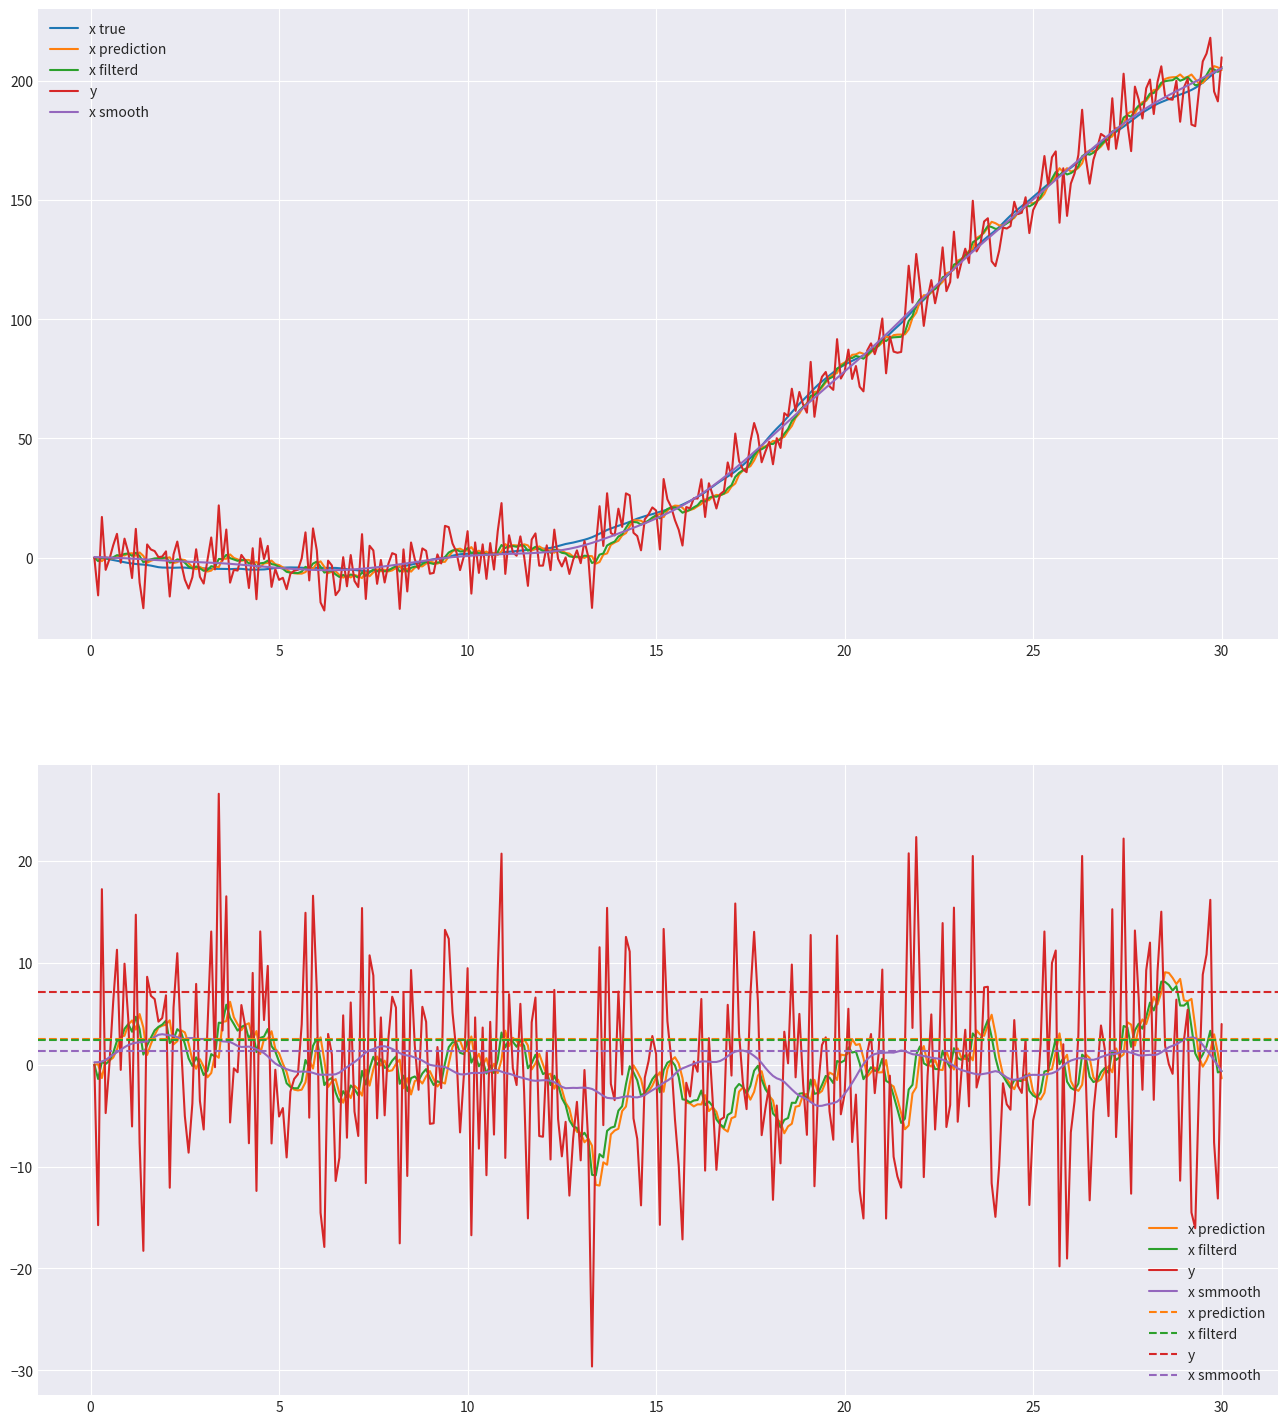

PyObject <matplotlib.legend.Legend object at 0x7fe87ff597b8>

In [178]:
fig, axes = plt.subplots(figsize=(16,9*2), 2)
ax = axes[1]
ax.plot(t, x_true[1,:], label="x true", color=colors[1])
ax.plot(t, k.x_pr[1,:], label="x prediction", color=colors[2])
ax.plot(t, k.x_fl[1,:], label="x filterd", color=colors[3])
ax.plot(t, y_true[:,:], label="y", color=colors[4])
ax.plot(t, k.x_sm[1,:], label="x smooth", color=colors[5])
ax.legend()

ax = axes[2]
x̂_pr_err =  k.x_pr[1,:] .- x_true[1,:]
x̂_fl_err =  k.x_fl[1,:] .- x_true[1,:]
x̂_sm_err =  k.x_sm[1,:] .- x_true[1,:]
y_err =  y_true[:,:] .- x_true[1,:]

ax.plot(t,x̂_pr_err, label="x prediction", color=colors[2])
ax.plot(t, x̂_fl_err, label="x filterd", color=colors[3])
ax.plot(t, y_err, label="y", color=colors[4])
ax.plot(t, x̂_sm_err, label="x smmooth", color=colors[5])

ax.axhline(mean((x̂_pr_err).^2 .|> sqrt), ls="--", color=colors[2], label="x prediction")
ax.axhline(mean((x̂_fl_err).^2 .|> sqrt), ls="--", color=colors[3], label="x filterd")
ax.axhline(mean((y_err).^2 .|> sqrt), ls="--", color=colors[4], label="y")
ax.axhline(mean((x̂_sm_err).^2 .|> sqrt), ls="--", color=colors[5],label="x smmooth")
ax.legend()

In [168]:
Union{Array, Missing}

Union{Missing, Array}

In [18]:

a = AbstractArray([1,2,3])
a <: AbstractArray

LoadError: [91mMethodError: no method matching AbstractArray(::Array{Int64,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  AbstractArray([91m::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY}[39m) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/qr.jl:399[39m
[91m[0m  AbstractArray([91m::LinearAlgebra.QRPivoted[39m) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/qr.jl:406[39m
[91m[0m  AbstractArray([91m::LinearAlgebra.LQ[39m) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/lq.jl:119[39m
[91m[0m  ...[39m

In [14]:
typeof(a)

Array{Int64,1}

In [27]:
y = [1,2,3,4,4]
y = zeros(1_000)

typeof(y) <: Vector
rs(x::Array) = reshape(x, length(x),1)
@benchmark(rs(y))

BenchmarkTools.Trial: 10000 samples with 987 evaluations.
 Range (min … max):  50.602 ns …   2.757 μs  ┊ GC (min … max): 0.00% … 97.98%
 Time  (median):     51.932 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   58.417 ns ± 117.649 ns  ┊ GC (mean ± σ):  8.97% ±  4.36%

  ▃▇██▆▄▂▁                                                     ▂
  ██████████▇█▇▇▇▇▇▆▆▆▆▆▅▆▄▄▄▄▄▄▄▅▅▆▄▆▇▇▇▆▇▅▆█▆▇▇▆▇▅▆▆▅▆▅▅▅▆▆▇ █
  50.6 ns       Histogram: log(frequency) by time      76.9 ns <

 Memory estimate: 96 bytes, allocs estimate: 2.

In [19]:
y

5-element Array{Int64,1}:
 1
 2
 3
 4
 4